In [18]:
%load_ext autoreload
%autoreload 2

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
from collections import defaultdict
from matplotlib import gridspec
from scipy.stats import pearsonr, spearmanr
from scipy import stats
from tqdm.auto import tqdm

# use LaTeX fonts in the plot
# https://ercanozturk.org/2017/12/16/python-matplotlib-plots-in-latex/
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# comparison with fischer

In [84]:
xx = np.random.random((10, 2))
yy = np.array([1, -1])

In [ ]:
base_dir = 'experiments/results/'
data_frames = []
for dd in os.listdir(base_dir):
    if not dd.startswith('nef-300-'):
        continue
    
    for df_name in ['fischer', 'fischer-val', 'genev', 'genev-val']:
        df = pd.read_csv('%s/%s/mosaic-%s-vaccine-evaluation.csv' % (base_dir, dd, df_name))
        df['name'] = df_name
        data_frames.append(df)

df = pd.concat(data_frames).reset_index()
df.head()

In [ ]:
def compare(df, feature, name1, name2):
    data1 = df[df.name == name1][feature].values
    data2 = df[df.name == name2][feature].values
    diff = data2 - data1
    tt = np.sqrt(len(diff)) * diff.mean() / diff.std(ddof=1)
    if np.isfinite(tt):
        pp = stats.t(df=len(diff) - 1).cdf(tt)
        if pp > 0.5:
            pp = 1 - pp
    else:
        tt, pp = 0, 0.5
    
    return np.mean(data1), tt, pp, np.mean(diff), np.std(diff)

In [ ]:
features = ['norm_prot_coverage', 'conservation', 'rel_pop_coverage', 'immunogen']

In [ ]:
for val in ['', '-val']:
    print('\ncomparing fischer and genev on %s data' % ('training' if not val else 'validation'))
    
    for feature in features:
        vv, tt, pp, dd, ss = compare(df, feature, 'genev', 'fischer')
        print('    feature: %20s | value: %.3f difference: %+.3f (%+.3f) - t value: %+.3f - p value: %.3f' % (feature, vv, dd, ss, tt, pp))

In [ ]:
for method in ['fischer', 'genev']:
    print('\ncomparing %s on training and validation data' % method)
    
    for feature in features:
        vv, tt, pp, dd, ss = compare(df, feature, method, method + '-val')
        print('    feature: %20s | value: %.3f difference: %+.3f (%+.3f) - t value: %+.3f - p value: %.3f' % (feature, vv, dd, ss, tt, pp))

# plots

In [20]:
sns.set()
sns.set_style('whitegrid')

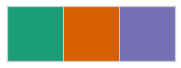

In [21]:
colorblindfriendly = [ '#1b9e77', '#d95f02', '#7570b3']
sns.palplot(colorblindfriendly)

In [22]:
def to_hex(r, g, b):
    return '#%02x%02x%02x' % (r,g,b)

to_hex(255,150, 9)

'#ff9609'

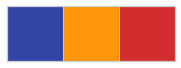

In [23]:
theme_dark = ['#3344a7', '#ff9609', '#d22d2f']
sns.palplot(theme_dark)

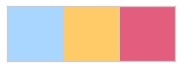

In [24]:
theme_light = [ '#a8d6ff', '#ffca68', '#e35e7e']
sns.palplot(theme_light)

In [25]:
def set_font_size(font_size):
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)   # fontsize of the figure title

In [26]:
plt.rc('axes', lw=0.8)
plt.rc('grid', lw=0.8)
plt.rc('lines', lw=0.8, markersize=4)
plt.rc('ytick.major', size=3, width=0.6)

# bound plot (fig. 7)

In [94]:
df = pd.read_csv('experiments/results/ig-bound-evaluation-aggregate.csv')
aaa = df.columns.tolist()
aaa[0] = 'metric'
df.columns = aaa

In [95]:
max_ig = df[df.metric == 'immunogen']['mean'].max()
df.loc[df.metric == 'immunogen', 'mean'] /= max_ig
df.loc[df.metric == 'immunogen', 'std'] /= max_ig

In [96]:
piv = df[
    df.metric.isin(['conservation', 'immunogen', 'norm_prot_coverage', 'rel_pop_coverage'])
].pivot_table('mean', 'vax', ['metric', 'aa'])
piv

metric       conservation                               immunogen            \
aa                    45        72        90        135       45        72    
vax                                                                           
conservation     0.483870  0.438932  0.445348  0.364559  0.246109  0.383222   
coverage         0.229653  0.102843  0.093274  0.119473  0.244772  0.453136   
immunogen        0.047162  0.081520  0.074465  0.056394  0.338361  0.550004   

metric                           norm_prot_coverage                      \
aa                 90        135                45        72        90    
vax                                                                       
conservation  0.506664  0.669933           0.941088  0.970585  0.970585   
coverage      0.563968  0.912304           0.974302  0.992646  0.998182   
immunogen     0.677303  1.000000           0.535520  0.870781  0.894498   

metric                 rel_pop_coverage                               
aa                 135              45        72        90       135  
vax                                                                   
conservation  0.979878         0.975143  0.955184  0.978420  0.97842  
coverage      0.998182         0.936219  0.971085  0.971085  0.98921  
immunogen     0.924360         0.965285  0.978420  0.978420  0.97842

In [97]:
vaxmap = {
    'coverage': 'Pathogen\ncoverage',
    'norm_prot_coverage': 'Pathogen\ncoverage',
    'immunogen': 'Immunogenicity',
    'conservation': 'Conservation',
    'rel_pop_coverage': 'Population\ncoverage',
}
piv = piv.rename(columns=vaxmap, index=vaxmap)
piv.index.name = 'Maximization Objective'
piv

metric                 Conservation                                \
aa                              45        72        90        135   
Maximization Objective                                              
Conservation               0.483870  0.438932  0.445348  0.364559   
Pathogen\ncoverage         0.229653  0.102843  0.093274  0.119473   
Immunogenicity             0.047162  0.081520  0.074465  0.056394   

metric                 Immunogenicity                                \
aa                                45        72        90        135   
Maximization Objective                                                
Conservation                 0.246109  0.383222  0.506664  0.669933   
Pathogen\ncoverage           0.244772  0.453136  0.563968  0.912304   
Immunogenicity               0.338361  0.550004  0.677303  1.000000   

metric                 Pathogen\ncoverage                                \
aa                                    45        72        90        135   
Maximization Objective                                                    
Conservation                     0.941088  0.970585  0.970585  0.979878   
Pathogen\ncoverage               0.974302  0.992646  0.998182  0.998182   
Immunogenicity                   0.535520  0.870781  0.894498  0.924360   

metric                 Population\ncoverage                               
aa                                      45        72        90       135  
Maximization Objective                                                    
Conservation                       0.975143  0.955184  0.978420  0.97842  
Pathogen\ncoverage                 0.936219  0.971085  0.971085  0.98921  
Immunogenicity                     0.965285  0.978420  0.978420  0.97842

In [98]:
pivot_mean = df[
    df.metric.isin(['conservation', 'immunogen', 'norm_prot_coverage', 'rel_pop_coverage'])
].pivot_table('mean', 'aa', ['metric', 'vax']).rename(columns=vaxmap)

pivot_std = df[
    df.metric.isin(['conservation', 'immunogen', 'norm_prot_coverage', 'rel_pop_coverage'])
].pivot_table('std', 'aa', ['metric', 'vax']).rename(columns=vaxmap)

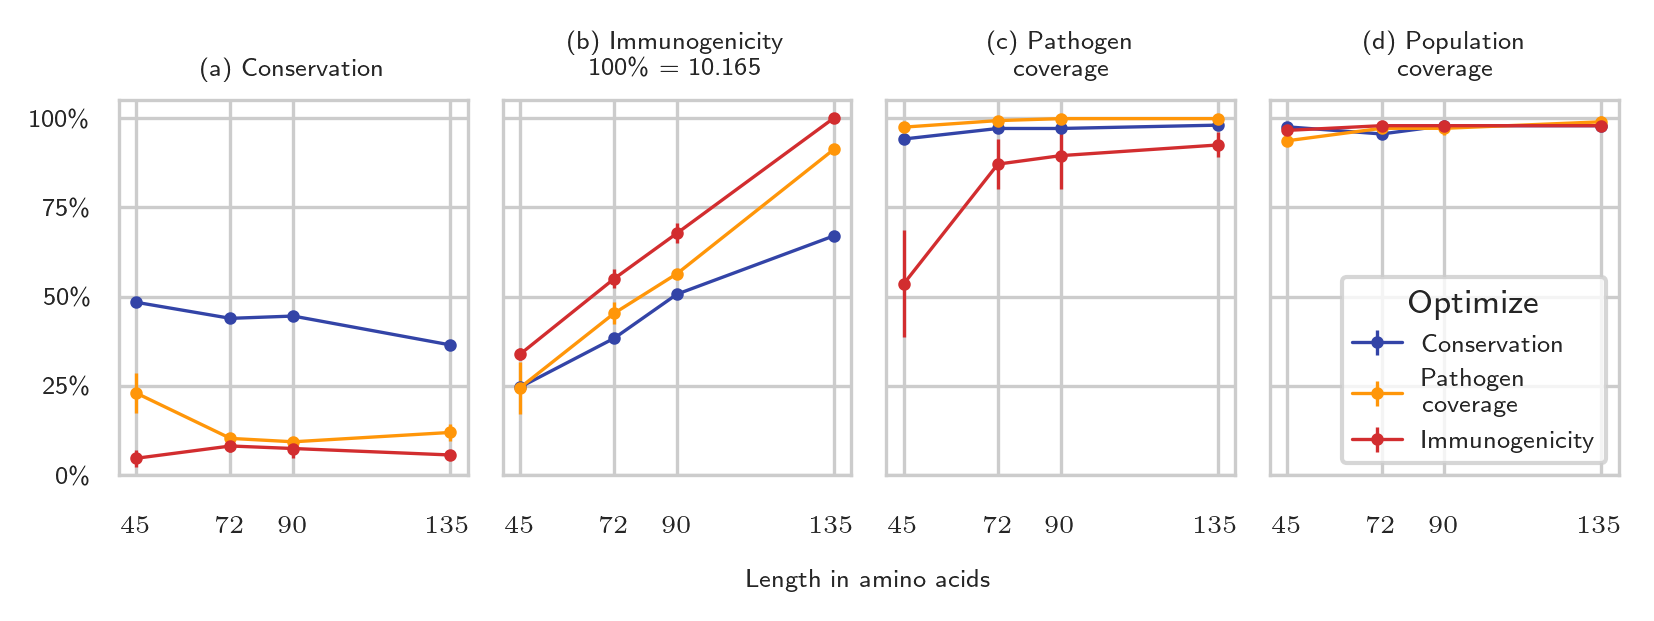

In [99]:
set_font_size(6)
plt.rc('legend', title_fontsize=8)

fig = plt.figure(figsize=(5, 5 / 4.), dpi=300)
grid = gridspec.GridSpec(1, 4, height_ratios=[1], width_ratios=[1, 1, 1, 1],
                         hspace=0.05, wspace=0.1, left=0, bottom=0, right=1, top=1,
                         figure=fig)

letters = ['(a) ', '(b) ', '(c) ', ' (d) ']
for i, (gg, col) in enumerate(zip(grid, pivot_mean.columns.levels[0])):
    ax = fig.add_subplot(gg)
    pivot_mean[col].plot.line(ax=ax, marker='.', yerr=pivot_std[col], color=theme_dark)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(40, 140)
    
    # title
    if col == 'Immunogenicity':
        ax.set_title(letters[i] + 'Immunogenicity\n100\%% = %.3f' % max_ig)
    else:
        ax.set_title(letters[i] + col)
    
    # y axis
    #ax.set_yticks([0., 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticks([0., 0.25, 0.5, 0.75, 1.0])
    if i > 0:
        ax.set_yticklabels([])
    else:
        #ax.set_yticklabels(['0\%', '20\%', '40\%', '60\%', '80\%', '100\%'])
        ax.set_yticklabels(['0\%', '25\%', '50\%', '75\%', '100\%'])
    
    # x axis
    ax.set_xlabel('')
    ax.set_xticks([45, 72, 90, 135])
    
    # legend
    if i == 3:
        ax.legend(loc='lower right', title='Optimize')
    else:
        ax.get_legend().remove()

fig.suptitle('Length in amino acids', y=-0.25)
plt.savefig('plots/bounds.tiff', bbox_inches='tight')

# pareto plot (fig. 3)

In [65]:
dfs = []
for i in range(1, 6):
    df = pd.read_csv('experiments/results/nef-300-%d/made-tradeoff.csv' % i)
    #df = pd.read_csv('/mnt/edo/home/edo/phd/extern/repos/GeneralizedEvDesign/experiments/results/nef-300-%d/made-tradeoff.csv' % i)
    df['rep'] = i
    dfs.append(df)
df = pd.concat(dfs)
df.head()

,immunogenicity,cleavage,epitopes,rep
0,2.827592,-7.353,FAFDLSFFL;AAFDLSWFL;LTFGWPFKL;YSLTFGWPF;WQFDRS...,1
1,2.751879,-9.826,FAFDLSFFL;SAFDLSFFL;AAFDLSFFL;WQFDRSLAL;LTFGWP...,1
2,2.668439,-12.069,FAFDLSFFL;LTFGWPFKL;AAFDLSWFL;WQFDRSLAL;YPPCFG...,1
3,2.557144,-14.215,FAFDLSFFL;LTFGWPYKL;MTWKGALNL;WQFDSRLAF;YPLCFG...,1
4,2.435258,-16.553,FAFDLSFFL;YPPCFGWCF;YPLTCGWCF;WQFDSRLAF;SAFDLS...,1


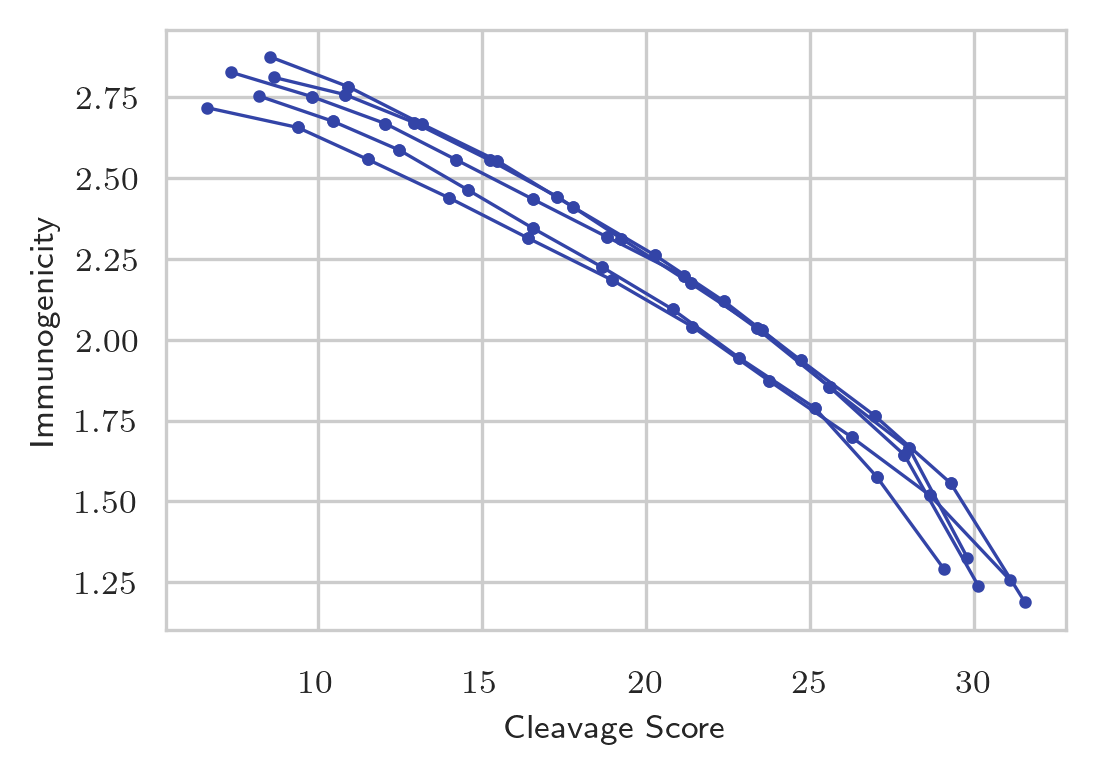

In [87]:
set_font_size(8)
fig, ax = plt.subplots(figsize=(3, 2), dpi=300)
cm = plt.get_cmap('RdBu_r')
vmin, vmax = 0.1, 1.2
for rep in df.rep.unique():
    data = df[df.rep == rep].values[:, :2]
    for i in range(len(data) - 1):
        (y1, x1), (y2, x2) = data[i], data[i + 1]
        slope = ((y2 - y1) / 3) / ((x2 - x1) / 40)
        color = 255 * (np.arctan(slope) - vmin) / (vmax - vmin)
        ax.plot([-x1, -x2], [y1, y2], '.-', color=theme_dark[0])


plt.xlabel('Cleavage Score')
plt.ylabel('Immunogenicity')
plt.subplots_adjust(hspace=0, wspace=0, left=0, bottom=0, right=1, top=1)
#sns.despine()
plt.savefig('plots/pareto.pdf', bbox_inches='tight')

# advantage (fig. 5)

In [ ]:
df = pd.read_csv('experiments/results/advantage-evaluation-summary.csv')
df.head()

In [ ]:
aaa = df.columns.tolist()
aaa[0] = 'metric'
df.columns = aaa

In [ ]:
df['vax'] = df.apply(lambda x: x['vax'] if '-' not in x['size'] else x['vax'] + '-' + x['size'].split('-')[1], axis=1)
df['size'] = df['size'].apply(lambda x: int(x.split('-')[0]))

In [ ]:
df.head()

In [ ]:
df[(df.vax == 'OptiTope') & (df.metric == 'norm_prot_coverage')].sort_values('size')

In [ ]:
df = df.replace({
    'optitope': 'OptiTope',
    'mosaic-o4': 'm4',
    'mosaic-o8': 'm8',
})

In [ ]:
set_font_size(8)

fig = plt.figure(figsize=(5, 2.5), dpi=300)
#gs = gridspec.GridSpec(2, 2, hspace=0.025, wspace=0.025, left=0, bottom=0, right=1, top=1)
gs = gridspec.GridSpec(2, 2, hspace=0.15, wspace=0.05, left=0, bottom=0, right=1, top=1)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

#fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

for i, vax in enumerate(df.vax.unique()):
    data = df[(df.vax == vax) & (df['size'] < 1000)].sort_values('size')
    
    data_ig = data[data.metric == 'immunogen']
    ax1.errorbar(data_ig['size'], data_ig['mean'], yerr=data_ig['std'], fmt='.-', label=vax, color=theme_dark[i])
    
    data_eps = data[data.metric == 'rel_pop_coverage']
    ax2.errorbar(data_eps['size'], data_eps['mean'], yerr=data_eps['std'], fmt='.-', label=vax, color=theme_dark[i])
    
    data_cov = data[data.metric == 'norm_prot_coverage']
    ax3.errorbar(data_cov['size'], data_cov['mean'], yerr=data_cov['std'], fmt='.-', label=vax, color=theme_dark[i])
    
    data_cons = data[data.metric == 'conservation']
    ax4.errorbar(data_cons['size'], data_cons['mean'], yerr=data_cons['std'], fmt='.-', label=vax, color=theme_dark[i])


xticks = range(0, 800, 90)
ax1.set_xlim(0, 750)
ax1.set_xticks(xticks)
ax2.set_xlim(0, 750)
ax2.set_xticks(xticks)
ax3.set_xlim(0, 750)
ax3.set_xticks(xticks)
ax4.set_xlim(0, 750)
ax4.set_xticks(xticks)

ax1.tick_params(axis='x', labelbottom=False)
ax2.tick_params(axis='x', labelbottom=False)

ax1.yaxis.set_ticks([0, 10, 20, 30, 40, 50])
ax2.yaxis.tick_right()
ax2.yaxis.set_ticks([0.9, 0.95, 1.0])
ax2.yaxis.set_ticklabels(['90\%', '95\%', '100\%'])
ax2.yaxis.set_label_coords(1.22, 0.5)
ax3.yaxis.set_ticks([0, 0.25, 0.50, 0.75, 1.0])
ax3.yaxis.set_ticklabels(['0\%', '25\%', '50\%', '75\%', '100\%'])
ax3.set_ylim(-0.05, 1.1)
ax4.yaxis.tick_right()
ax4.set_ylim(0, 0.09)
ax4.yaxis.set_ticklabels(['0.0\%', '2.5\%', '5.0\%', '7.5\%', '10.0\%'])
ax4.yaxis.set_label_coords(1.22, 0.5)

ax3.set_xlabel('Length in Aminoacids')
ax4.set_xlabel('Length in Aminoacids')

ax1.set_ylabel('Immunogenicity')
ax2.set_ylabel('Pop. Coverage')
ax3.set_ylabel('Pathogen Cov.')
ax4.set_ylabel('Conservation')

tt1 = ax1.set_title('(a)')
tt2 = ax2.set_title('(b)')
tt3 = ax3.set_title('(c)')
tt4 = ax4.set_title('(d)')

tt1.set_position((0.53, 0.82))
tt2.set_position((0.53, 0.82))
tt3.set_position((0.53, 0.0))
tt4.set_position((0.53, 0.0))

ax1.legend(loc='upper left')

plt.savefig('plots/advantage.tiff', bbox_inches='tight')

# cocktail (fig. 4)

We parse the log file and look for this piece:

```
2019-09-24 10:51:58,687 INFO: The polypeptide has 184 epitopes 
2019-09-24 10:51:58,687 INFO: The epitopes have immunogenicity 2.316
2019-09-24 10:51:58,687 INFO: The epitopes cover 27 alleles
2019-09-24 10:51:58,687 INFO: The maximum population coverage is 91.29%
2019-09-24 10:51:58,687 INFO: The epitopes cover 91.29% of the population (100.00% of the maximum)
2019-09-24 10:51:58,688 INFO: The epitopes cover 1736 proteins (90.56% of the total)
2019-09-24 10:51:58,688 INFO: The average epitope conservation is 13.17%
```

Every piece is about a different chain, exept for the last one which is about the vaccine as a whole.

In [74]:
import re

epis, immunogs, popc, protc, cons = [], [], [], [], []
with open('experiments/results/hiv1bc-full/mosaic-4cocktail-evaluation.log') as f:
    for row in f:
        match = re.search(r'The polypeptide has (\d+) epitopes', row)
        if match:
            epis.append(int(match.group(1)))
            continue
        
        match = re.search(r'The epitopes have immunogenicity ([0-9.]+)', row)
        if match:
            immunogs.append(float(match.group(1)))
            continue
        
        match = re.search(r'The epitopes cover [0-9.]+% of the population \(([0-9.]+)% of the maximum\)', row)
        if match:
            popc.append(float(match.group(1)) / 100)
            continue
        
        match = re.search(r'The epitopes cover \d+ proteins \(([0-9.]+)% of the total\)', row)
        if match:
            protc.append(float(match.group(1)) / 100)
            continue
        
        match = re.search(r'The average epitope conservation is ([0-9.]+)%', row)
        if match:
            cons.append(float(match.group(1)) / 100)

In [75]:
mos_df = pd.DataFrame({
    'num_epitopes': epis,
    'immunogen': immunogs,
    'rel_pop_coverage': popc,
    'norm_prot_coverage': protc,
    'conservation': cons,
    'vax': ['chain-%d' % i for i in range(len(epis) - 1)] + ['mosaic'],
})
mos_df

,num_epitopes,immunogen,rel_pop_coverage,norm_prot_coverage,conservation,vax
0,46,3.350,0.9709,0.8367,0.1628,chain-0
1,46,2.210,0.8178,0.9061,0.1377,chain-1
2,46,3.210,0.9418,0.8998,0.1647,chain-2
3,46,3.467,0.9570,0.9457,0.2915,chain-3
4,184,12.236,0.9839,0.9896,0.1892,mosaic


In [76]:
ot_df = pd.read_csv('experiments/results/hiv1bc-full/optitope-p99-evaluation.csv')
ot_df = ot_df.drop(['prot_coverage', 'alleles', 'pop_coverage', 'max_pop_coverage'], axis=1)
ot_df['vax'] = 'optitope'
ot_df

,norm_prot_coverage,num_epitopes,conservation,rel_pop_coverage,immunogen,vax
0,0.989045,24,0.098809,1.0,5.631012,optitope


In [77]:
highig_df = pd.read_csv('experiments/results/hiv1bc-full/mosaic-highig-evaluation.csv')
highig_df = highig_df.drop(['prot_coverage', 'alleles', 'pop_coverage', 'max_pop_coverage'], axis=1)
highig_df['vax'] = 'highig'
highig_df

,norm_prot_coverage,num_epitopes,conservation,rel_pop_coverage,immunogen,vax
0,0.962963,208,0.060747,0.97842,14.551378,highig


In [78]:
df = pd.concat([mos_df, ot_df, highig_df], sort=True)
df

,conservation,immunogen,norm_prot_coverage,num_epitopes,rel_pop_coverage,vax
0,0.162800,3.350000,0.836700,46,0.97090,chain-0
1,0.137700,2.210000,0.906100,46,0.81780,chain-1
2,0.164700,3.210000,0.899800,46,0.94180,chain-2
3,0.291500,3.467000,0.945700,46,0.95700,chain-3
4,0.189200,12.236000,0.989600,184,0.98390,mosaic
0,0.098809,5.631012,0.989045,24,1.00000,optitope
0,0.060747,14.551378,0.962963,208,0.97842,highig


In [79]:
def num_epis_to_num_aas(x):
    if x['vax'].startswith('chain') or x['vax'] == 'highig':
        return x['num_epitopes'] + 8
    elif x['vax'] == 'mosaic':
        return 0.0
    elif x['vax'] == 'optitope':
        return x['num_epitopes'] * 9
    
df['num_aas'] = df.apply(num_epis_to_num_aas, axis=1)
df.loc[(df.vax == 'mosaic'), 'num_aas'] = df[df.vax.str.startswith('chain-')].num_aas.sum()

max_short, max_aas = df.immunogen.max(), df.num_aas.max()
df.immunogen = df.immunogen / max_short
df.num_aas = df.num_aas / max_aas

In [80]:
res = df.drop(['vax', 'num_epitopes'], axis=1).T
res.columns = df.vax
res

vax,chain-0,chain-1,chain-2,chain-3,mosaic,optitope,highig
conservation,0.162800,0.137700,0.164700,0.291500,0.189200,0.098809,0.060747
immunogen,0.230219,0.151876,0.220598,0.238259,0.840883,0.386974,1.000000
norm_prot_coverage,0.836700,0.906100,0.899800,0.945700,0.989600,0.989045,0.962963
rel_pop_coverage,0.970900,0.817800,0.941800,0.957000,0.983900,1.000000,0.978420
num_aas,0.250000,0.250000,0.250000,0.250000,1.000000,1.000000,1.000000


In [81]:
res = res.rename(index={
    'conservation': 'Epitope\nConservation',
    'immunogen': 'Immunogen.\n100\\%%=%.3f' % max_short,
    'norm_prot_coverage': 'Pathogen\nCoverage',
    'rel_pop_coverage': 'Population\nCoverage',
    'num_aas': 'Amino Acids\n100\\%%=%d' % max_aas,
})

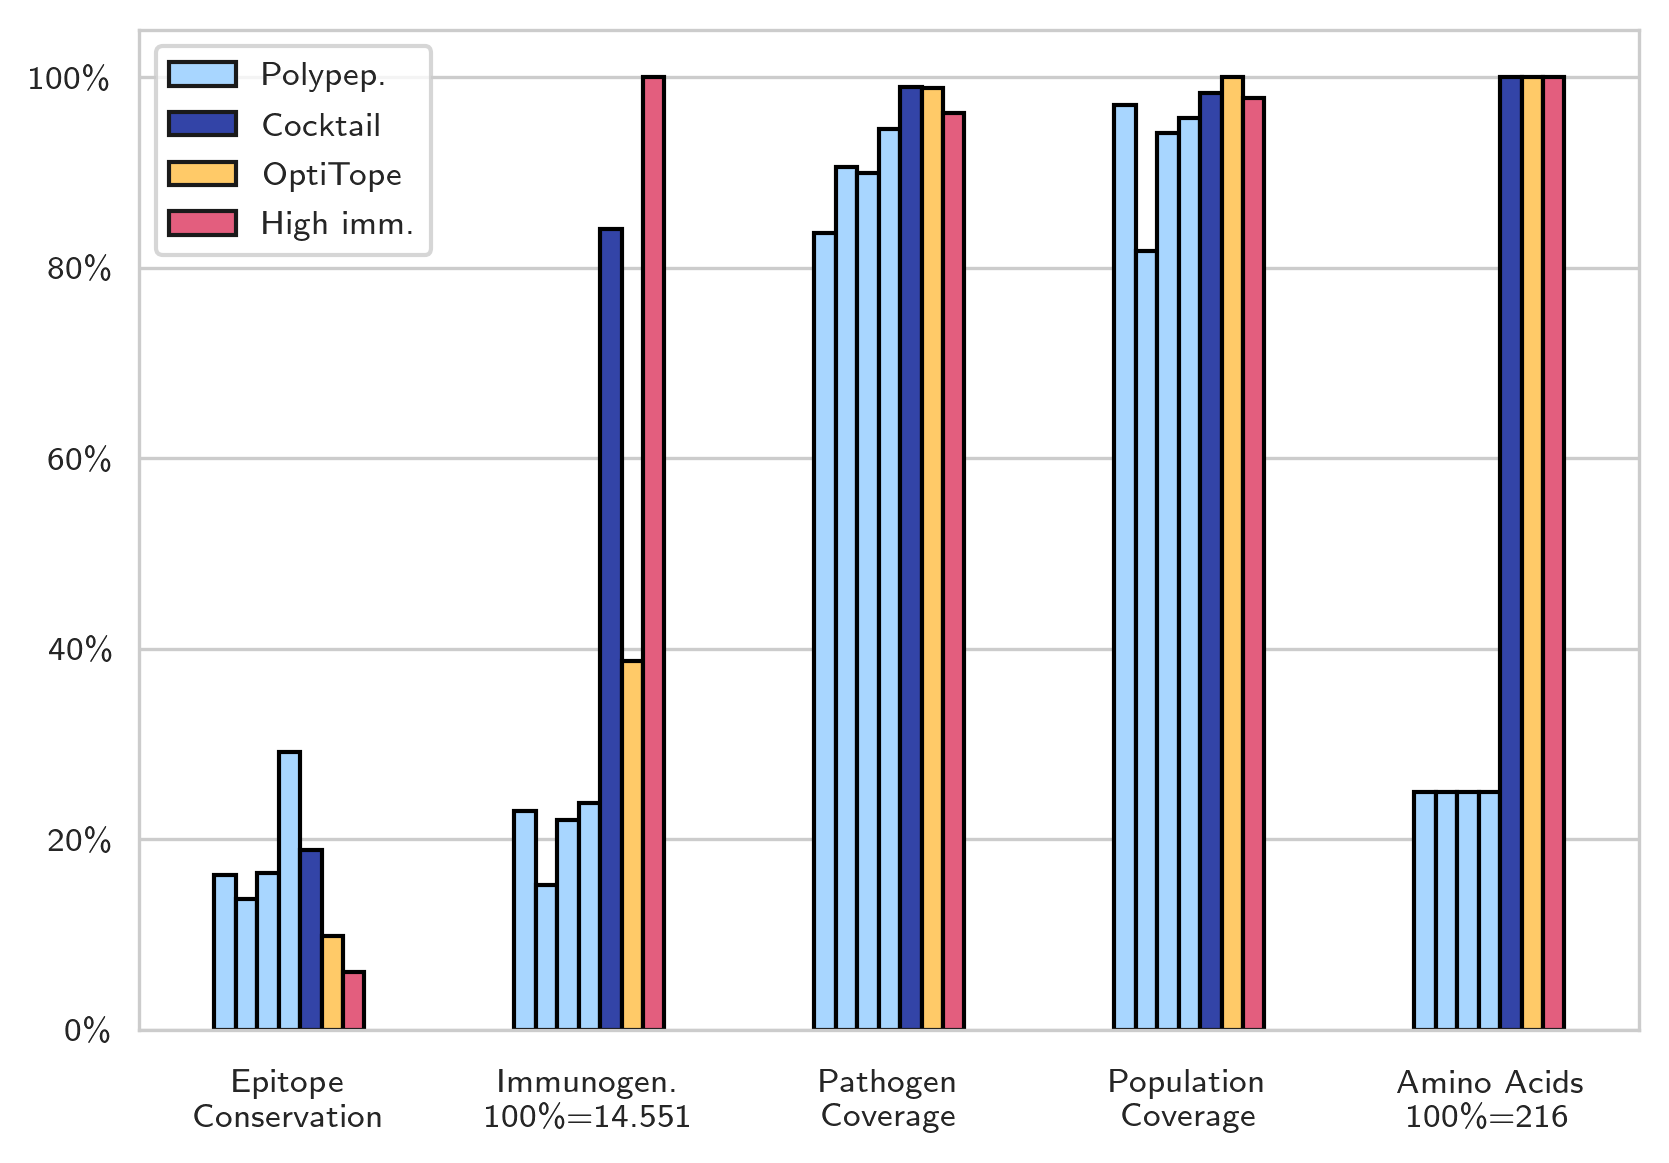

In [93]:
set_font_size(8)
fig, ax = plt.subplots(figsize=(5, 5 * 2 / 3.), dpi=300)

#color = [theme_light[0]] * 4 + [theme_light[1], theme_light[2]]
#ax.bar(x=[x - 0.25 for x in range(5)], width=0.32, height=res.mosaic, align='edge', edgecolor='k', linewidth=2, color='white')
#res.drop('mosaic', axis=1).plot.bar(color=color, rot=0, legend=False, ax=ax, edgecolor='black')

color = [theme_light[0]] * 4 + [theme_dark[0], theme_light[1], theme_light[2]]
res.plot.bar(color=color, rot=0, legend=False, ax=ax, edgecolor='black')

plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ['0\%', '20\%', '40\%', '60\%', '80\%', '100\%'])

plt.legend(handles=[
    mpatches.Patch(facecolor=color[0], edgecolor='k', label='Polypep.'),
    #mpatches.Patch(facecolor='#ffffff', edgecolor='k', label='Cocktail'),
    mpatches.Patch(facecolor=color[4], edgecolor='k', label='Cocktail'),
    mpatches.Patch(facecolor=color[5], edgecolor='k', label='OptiTope'),
    mpatches.Patch(facecolor=color[6], edgecolor='k', label='High imm.'),
])
plt.grid(False, axis='x')

plt.subplots_adjust(hspace=0, wspace=0, left=0, bottom=0, right=1, top=1)
#sns.despine()

plt.savefig('plots/cocktail.tiff', bbox_inches='tight')

# correlate coverage with variations and immunogenicity (fig. 6)

## find covered positions

In [ ]:
def read_fasta(fname):
    with open(fname) as f:
        prots = {}
        for row in f:
            row = row.strip()
            if row.startswith('>'):
                pid = row[1:]
                prots[pid] = []
            else:
                prots[pid].append(row)
    return {pid: ''.join(ps) for pid, ps in prots.items()}

prots = read_fasta('experiments/resources/hiv1-bc-nef.fasta')

In [ ]:
def read_vax(vax_file):
    with open(vax_file) as f:
        _ = next(f)
        peps = [r.split(',')[-1].strip() for r in f]
    return peps


vax_short = read_vax('experiments/results/hiv1bc-full/mosaic-entropy-short.csv')
vax_sob = read_vax('experiments/results/hiv1bc-full/optitope-entropy.csv')
vax_mid = read_vax('experiments/results/hiv1bc-full/mosaic-entropy-mid.csv')
vax_long = read_vax('experiments/results/hiv1bc-full/mosaic-entropy-long.csv')

In [ ]:
def find_coverage_by_protein(prots, vax, sort=False):
    # step 1: find all occurrences of all epitopes
    vax = set(vax)
    peps = defaultdict(list)
    for i, pp in enumerate(prots.values()):
        for j in range(len(pp) - 8):
            seq = pp[j:j+9]
            if seq in vax:
                peps[seq].append((i, j))
    
    # step 2: aggregate the positions by protein
    mat = np.zeros((len(prots), max(len(p) for p in prots.values())))
    for poss in peps.values():
        for i, j in poss:
            mat[i, j:j+9] += 1
    
    # step 3: sort by similarity
    if sort:
        link = hierarchy.linkage(mat, 'ward')
        idx = hierarchy.leaves_list(link)
        mat = mat[idx]
    
    return mat


mat_short = find_coverage_by_protein(prots, vax_short)
mat_mid = find_coverage_by_protein(prots, vax_mid)
mat_long = find_coverage_by_protein(prots, vax_long)
mat_sob = find_coverage_by_protein(prots, vax_sob)

In [ ]:
plt.matshow(mat_sob.T)

In [ ]:
idx = np.random.choice(len(prots), len(prots))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
ax1.matshow(mat_short[idx].T, cmap='Reds')
ax1.grid(False)
ax1.set_xlabel('Protein')
ax1.xaxis.set_label_position('top') 
ax1.set_ylabel('Position')
ax2.set_ylabel('Position')
ax2.matshow(mat_long[idx].T, cmap='Reds')
ax2.grid(False)
ax2.set_title('Top: Short mosaic - Bottom: Long mosaic')
ax2.tick_params(axis='x', labeltop=False)
fig.set_tight_layout(True)
fig.subplots_adjust(left=0, bottom=-0.35, right=1, top=1, wspace=0, hspace=0)
fig.savefig('plots/epitopes-positions.pdf', bbox_inches='tight')

## find immunogenicity by position

In [ ]:
with open('experiments/results/hiv1bc-full/made-epitopes.csv') as f:
    _ = next(f)
    epitope_immunogen = {row.split(',')[-1].strip(): float(row.split(',')[0]) for row in f}

peps = defaultdict(list)
for i, pp in enumerate(prots.values()):
    for j in range(len(pp) - 8):
        seq = pp[j:j+9]
        if seq in epitope_immunogen:
            peps[seq].append((i, j))

# step 2: aggregate the positions by protein
mat = np.zeros((len(prots), max(len(p) for p in prots.values())))
counts = np.zeros((len(prots), max(len(p) for p in prots.values())))
for pep, positions in peps.items():
    for i, j in positions:
        mat[i, j:j+9] += epitope_immunogen[pep]
        counts[i, j:j+9] += 1

#avg = mat.sum(axis=0) / counts.sum(axis=0)
#ig_val = np.where(np.isfinite(avg), avg, 0.0)
ig_mat = mat

In [ ]:
plt.matshow(ig_mat.T)

## find entropy by position

In [ ]:
# from https://mafft.cbrc.jp/alignment/server/
aligned = read_fasta('plots/aligned.fasta')

In [ ]:
aminos = sorted(set(a for p in prots.values() for a in p)) + ['-']
counts = np.zeros((max(len(a) for a in aligned.values()), len(aminos) + 1))
for p in aligned.values():
    for i, a in enumerate(p):
        counts[i, aminos.index(a)] += 1

In [ ]:
# remove gaps from aligned counts
#aminocounts = np.array([c for c in counts if np.argmax(c) < len(aminos) - 1])
aminocounts = counts

In [ ]:
plt.matshow(aminocounts.T)
plt.grid(False)

In [ ]:
# aggregate counts for same position
# idea 1: just sum how many different aminoacids
ss = np.sum(aminocounts > 0, axis=1)

# idea 2: entropy
ps = aminocounts / np.sum(aminocounts, axis=1, keepdims=True)
es = -ps * np.log(ps)
ss = np.sum(np.where(np.isfinite(es), es, 0.0), axis=1)

# smooth
variants = pd.Series(ss).rolling(9, center=True, win_type='triang').mean()

In [ ]:
plt.plot(variants)

## align immunogenicity and coverage

In [ ]:
# step 3: use alignments
ordered_alignments = [aligned[k] for k in prots]


def align_matrix(mat):
    # mat is (proteins,positions)
    # expand the positions to account for the alignment
    res = np.zeros((len(mat), max(len(a) for a in ordered_alignments)))
    for i, values in enumerate(mat):
        cursor = 0
        for j, a in enumerate(ordered_alignments[i]):
            if a != '-':
                res[i, j] = mat[i, cursor]
                cursor += 1
    return res


ig_ali = align_matrix(ig_mat)
short_ali = align_matrix(mat_short)
mid_ali = align_matrix(mat_mid)
long_ali = align_matrix(mat_long)
sob_ali = align_matrix(mat_sob)

In [ ]:
plt.matshow(sob_ali.T)

In [ ]:
consensus_positions = np.argmax(counts, axis=1) < len(aminos) - 1

cov_long = long_ali.sum(axis=0)[consensus_positions]
cov_long /= cov_long.max()

cov_mid = mid_ali.sum(axis=0)[consensus_positions]
cov_mid /= cov_mid.max()

cov_short = short_ali.sum(axis=0)[consensus_positions]
cov_short /= cov_short.max()

cov_sob = sob_ali.sum(axis=0)[consensus_positions]
cov_sob /= cov_sob.max()

cov_ig = ig_ali.sum(axis=0)[consensus_positions] / len(prots)
ent_smo = variants[consensus_positions]
ent = ss[consensus_positions]

## correlations

In [ ]:
agg = pd.DataFrame({
    'Immuno,': cov_ig,
    'Entropy': ent_smo,
    'Long Mosaic': cov_long,
    'Short Mosaic': cov_short,
    'OptiTope': cov_sob,
})

In [ ]:
corrs = agg.corr()
corrs

## plot everything together

In [ ]:
set_font_size(6)

fig = plt.figure(figsize=(5.2, 5.2 / 4), dpi=300)

gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[3, 1],
                       hspace=0.05, wspace=0.1, left=0, bottom=0, right=1, top=1,
                       figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])

ax12 = ax1.twinx()
p1 = ax1.plot(ent_smo.values, color='#1f78b4', label='Entropy')
ax1.plot(ent, color='#1f78b4', alpha=0.2)
p2 = ax12.plot(cov_ig, color='#33a02c', label='Immuno.')

p3 = ax2.plot(cov_mid, color=theme_dark[0], label='Long Mosaic')
p5 = ax2.plot(cov_sob, color=theme_dark[1], label='OptiTope')
p4 = ax2.plot(cov_short, color=theme_dark[2], label='Short Mosaic')

# adjust chart
ax1.set_title('(a)')
ax2.set_title('(b)', pad=-8)
ax1.set_ylabel('Entropy')
ax1.set_yticks([0, 1, 2])
ax12.set_ylabel('Immuno.')
ax12.set_yticks([0, 0.5, 1])

ax12.yaxis.set_label_coords(0.97, 0.5)
ax1.tick_params(axis='x', labelbottom=False)
ax1.grid(True, axis='x')
ax12.grid(False)

ax1.legend(p1 + p2, [p.get_label() for p in p1 + p2], ncol=2, loc='upper left', bbox_to_anchor=(-0.012, 1.06))
ax2.legend(ncol=1, loc='upper left',
           bbox_to_anchor=(-0.012, 1.07))
ax2.set_xlabel('Position')
ax2.set_ylabel('Rel. Coverage')

ax1.set_xticks(range(0, 210, 18))
ax2.set_xticks(range(0, 210, 18))
ax2.set_yticks([0, 0.5, 1.0])
ax1.set_ylim(0, 2.15)
ax12.set_ylim(0, 1.1)
ax2.set_ylim(0, 1.1)

# scatter matrix
cm = plt.get_cmap('bwr')
gs00 = gridspec.GridSpecFromSubplotSpec(5, 5, subplot_spec=gs[:,1], hspace=0, wspace=0)
for i in range(len(corrs)):
    for j in range(len(corrs)):
        plot = fig.add_subplot(gs00[i, j])
        
        plot.set_xticks([])
        plot.set_yticks([])

        # write correlation coeff and pval in the lower triangular half
        xs, ys = agg.iloc[4:-4, j], agg.iloc[4:-4, i]
        if i > j:
            corr = spearmanr(xs, ys)
            plot.set_facecolor(cm(int(128 + corr[0] * 128)))
            
            # bold if significant (with bonferroni correction)
            if corr[1] < 0.05 / 10:
                fmt = '\\textbf{{{:.3f}}}\n\\textbf{{{:.0e}}}'
            else:
                fmt = '{:.3f}\n{:.0e}'

            plot.text(0.5, 0.5, fmt.format(*corr),
                      fontdict={'size': 'small'},
                      horizontalalignment='center',
                      verticalalignment='center',
                      weight='bold',
                      transform=plot.transAxes)

        # add regression line to upper triangular half
        elif i < j:
            plot.scatter(xs, ys, alpha=0.2, marker='.')
            xs = np.vstack([xs, np.ones(len(xs))])
            ws = np.linalg.inv(xs.dot(xs.T) + 1e-6 * np.eye(2)).dot(xs).dot(ys)
            xlims, ylims = plot.get_xlim(), plot.get_ylim()
            reg = xlims[0] * ws[0] + ws[1], xlims[1] * ws[0] + ws[1]
            plot.plot(xlims, reg, 'C3')
            plot.set_ylim(ylims)
            plot.set_xlim(xlims)

        # histogram on the diagonal
        else:
            plot.hist(xs)
            plot.set_yscale('log')
            plot.grid(False)
            plot.tick_params(axis='both', which='both', left=False,
                             bottom=False, labelleft=False)

        # put labels on the bottom / right
        if j == len(corrs) - 1:
            plot.set_ylabel(corrs.columns[i], rotation=-45, ha='left')
            plot.yaxis.set_label_coords(1.4, 0.5)
        if i == len(corrs) - 1:
            plot.set_xlabel(corrs.columns[j], rotation=-45, ha='left')
        if i == 0 and j == 2:
            plot.set_title('(c)')

#sns.despine(fig, ax2, top=True, right=False)

fig.savefig('plots/positions-entropy.tiff', bbox_inches='tight')

# compare rank and ic50 immunogenicities

In [112]:
rank_ig_rank, ic50_ig_rank, cleav_rank = [], [], []
rank_ig_ic50, ic50_ig_ic50, cleav_ic50 = [], [], []
all_epi_ic50, all_epi_ranks = [], []
for i in range(1, 6):
    epi_rank_ig = {}
    with open(f'experiments/results/nef-300-{i}/made-netmhcpan-rank-epitopes.csv') as f:
        header = next(f).strip().split(',')
        for row in f:
            row = dict(zip(header, row.strip().split(',')))
            epi_rank_ig[row['epitope']] = float(row['immunogen'])

    epi_ic50_ig = {}
    with open(f'experiments/results/nef-300-{i}/made-epitopes.csv') as f:
        header = next(f).strip().split(',')
        for row in f:
            row = dict(zip(header, row.strip().strip().split(',')))
            epi_ic50_ig[row['epitope']] = float(row['immunogen'])
    
    with open(f'experiments/results/nef-300-{i}/made-netmhcpan-rank-tradeoff.csv') as f:
        header = next(f).strip().split(',')
        for row in f:
            row = dict(zip(header, row.strip().strip().split(',')))
            rank_ig_rank.append(sum(epi_rank_ig[e] for e in row['epitopes'].split(';')))
            ic50_ig_rank.append(sum(epi_ic50_ig[e] for e in row['epitopes'].split(';')))
            cleav_rank.append(float(row['cleavage']))
            all_epi_ranks.append(set(row['epitopes'].split(';')))

    with open(f'experiments/results/nef-300-{i}/made-tradeoff.csv') as f:
        header = next(f).strip().split(',')
        for row in f:
            row = dict(zip(header, row.strip().strip().split(',')))
            rank_ig_ic50.append(sum(epi_rank_ig[e] for e in row['epitopes'].split(';')))
            ic50_ig_ic50.append(sum(epi_ic50_ig[e] for e in row['epitopes'].split(';')))
            cleav_ic50.append(float(row['cleavage']))
            all_epi_ic50.append(set(row['epitopes'].split(';')))
    
pd.DataFrame({
    'iou': [len(r & i) / len(r | i) for r, i in zip(all_epi_ranks, all_epi_ic50)],
    'cnt': [len(r & i) for r, i in zip(all_epi_ranks, all_epi_ic50)],
}).describe()

,iou,cnt
count,55.000000,55.000000
mean,0.177612,2.872727
std,0.113970,1.528186
min,0.000000,0.000000
25%,0.111111,2.000000
50%,0.176471,3.000000
75%,0.250000,4.000000
max,0.538462,7.000000


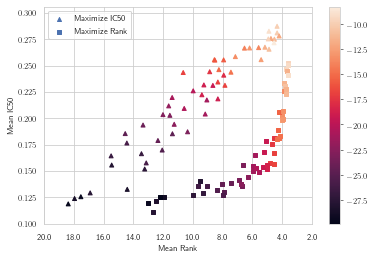

In [113]:
plt.scatter(np.array(rank_ig_ic50) / 10, np.array(ic50_ig_ic50) / 10,
            c=cleav_ic50, marker='^', label='Maximize IC50')
plt.xlabel('Mean Rank')
plt.ylabel('Mean IC50')
plt.scatter(np.array(rank_ig_rank) / 10, np.array(ic50_ig_rank) / 10,
            c=cleav_rank, marker='s', label='Maximize Rank')
xticks, _ = plt.xticks()
plt.xticks(xticks, 100 - xticks)
plt.colorbar()
plt.legend()
plt.show()

In [114]:
plt.hexbin(100-np.array(all_epi_ranks), all_epi_ic50, bins='log')
plt.colorbar()
plt.xlabel('Rank Ig.')
plt.ylabel('IC50 Ig.')
plt.title('Epitope Immunogenicity')
#plt.xticks(range(0, 101, 20), range(100, -1, -20))
plt.xlim(3, 100)
plt.ylim(0, 0.3)
plt.show()

TypeError: unsupported operand type(s) for -: 'int' and 'set'

QUESTION: why is rank always larger than 2/3 %

ANSWER: it is a weighted average of rank across all alleles

# compare optimized cleavage with shuffled epitopes

In [59]:
from data_preparation import get_cleavage_score_process

In [60]:
immunogen, cleavage = [], []
for i in tqdm(range(1, 6)):
    with open(f'experiments/results/nef-300-{i}/made-tradeoff.csv') as f:
        header = next(f).strip().split(',')
        for row in tqdm(f, leave=False, total=10):
            row = dict(zip(header, row.strip().split(',')))
            epis = row['epitopes'].split(';')
            
            immunogen.append(float(row['immunogenicity']))
            cleavage.append(float(row['cleavage']))
            
            for i in range(50):
                np.random.shuffle(epis)
                immunogen.append(float(row['immunogenicity']))
                cleavage.append(sum(x[2] for x in get_cleavage_score_process(
                    penalty=0.1, cleavage_model='pcm', window_size=5,
                    epitopes=list(zip(epis[:-1], epis[1:]))
                )))

Text(0, 0.5, 'Cleavage score')

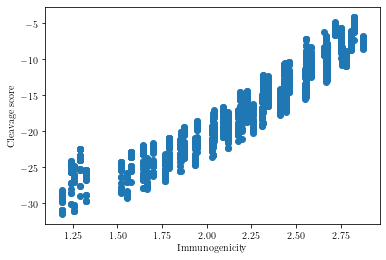

In [64]:
plt.scatter(immunogen, cleavage)
plt.xlabel('Immunogenicity')
plt.ylabel('Cleavage score')

In [62]:
df = pd.DataFrame({'immunogen': immunogen, 'cleavage': cleavage})

# overall decrease in cleavage score
df.groupby('immunogen').apply(lambda g:
    100 * (1 - g['cleavage'].iloc[1:] / g['cleavage'].iloc[0])
).describe()

count    2750.000000
mean       13.855661
std         7.507895
min        -0.000002
25%         8.463989
50%        13.357178
75%        17.950077
max        44.648443
Name: cleavage, dtype: float64

In [63]:
# decrease by immunogenicity
df.groupby('immunogen').apply(lambda g: (
    # compute percent increase compared to first (the optimized one)
    100 * (1 - g['cleavage'].iloc[1:] / g['cleavage'].iloc[0])
).describe()) #.plot(y='max')

cleavage,count,mean,std,min,25%,50%,75%,max
immunogen,,,,,,,,
1.187579,50.0,6.717137,2.124105,4.909724e-01,5.932848,7.275895,8.297434,10.475135
1.238395,50.0,14.787873,3.941469,1.110223e-14,14.733639,15.387932,16.583740,19.773112
1.255770,50.0,14.011890,4.666735,1.110223e-14,13.989042,14.492754,15.800636,20.190237
1.291974,50.0,17.309705,3.550404,4.964076e+00,17.223005,17.743821,17.924301,22.850562
1.325758,50.0,11.006407,3.400944,0.000000e+00,11.037033,11.383382,12.819932,14.924021
1.518648,50.0,11.667620,4.305346,8.475167e-01,11.618478,12.852260,14.374651,15.126256
1.556389,50.0,8.328248,2.976312,5.255793e-01,7.876011,9.303437,9.904099,11.576397
1.576701,50.0,12.570425,2.681518,5.354436e+00,12.720482,13.215989,13.600562,15.467958
1.643785,50.0,15.086450,5.179990,2.220446e-14,11.592384,16.961885,18.887375,21.216250


# show peptides overlap

In [87]:
def load_epis(fname):
    with open(fname) as f:
        _ = next(f)
        epis = []
        for row in f:
            epis.append(row[:-1].split(',')[-1])
    return {e: i for i, e in enumerate(sorted(epis))}


epis = [
    load_epis('experiments/results/nef-300-%d/made-epitopes.csv' % i)
    for i in range(1, 6)
]

all_epis = load_epis('experiments/results/hiv1bc-full/made-epitopes.csv')

In [88]:
# pairwise overlaps
ovs = np.zeros((len(epis), len(epis)))
for i in range(len(epis)):
    for j in range(len(epis)):
        ovs[i, j] = len(epis[i].keys() & epis[j].keys()) / max(len(epis[i].keys()), len(epis[j].keys()))
ovs

array([[1.        , 0.44366403, 0.47742082, 0.4796778 , 0.46832628],
       [0.44366403, 1.        , 0.46136962, 0.47600234, 0.45899993],
       [0.47742082, 0.46136962, 1.        , 0.45846881, 0.45892819],
       [0.4796778 , 0.47600234, 0.45846881, 1.        , 0.46911543],
       [0.46832628, 0.45899993, 0.45892819, 0.46911543, 1.        ]])

In [89]:
coverage = np.zeros((len(epis), len(all_epis)))
for e, i in all_epis.items():
    for j, b in enumerate(epis):
        if e in b:
            coverage[j, i] = 1

np.mean(coverage, axis=1)  # portion of covered epitopes 

array([0.25003794, 0.2592958 , 0.25037942, 0.25671574, 0.26443694])

In [90]:
# try to sort stuff decently
mat = np.array(sorted(coverage.T, key=lambda x: sum(x))).T
link = hierarchy.linkage(mat, 'ward')
idx = hierarchy.leaves_list(link)
mat = mat[idx]

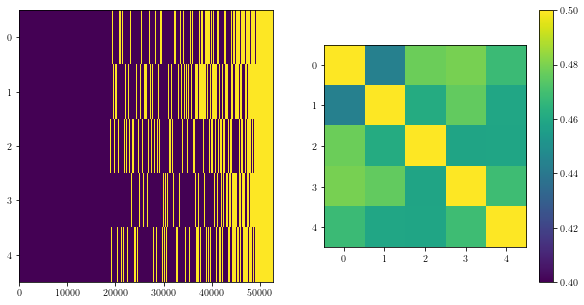

In [91]:
fig = plt.figure(figsize=(10, 5))
ax1, ax2 = fig.subplots(1, 2,)

ax1.imshow(mat, aspect='auto')
ax1.grid(False)

im = ax2.imshow(ovs, vmin=0.4, vmax=0.5)
fig.colorbar(im, ax=ax2)